# Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading and Visualising the data

Found 202599 files.


2024-11-01 16:40:07.714110: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


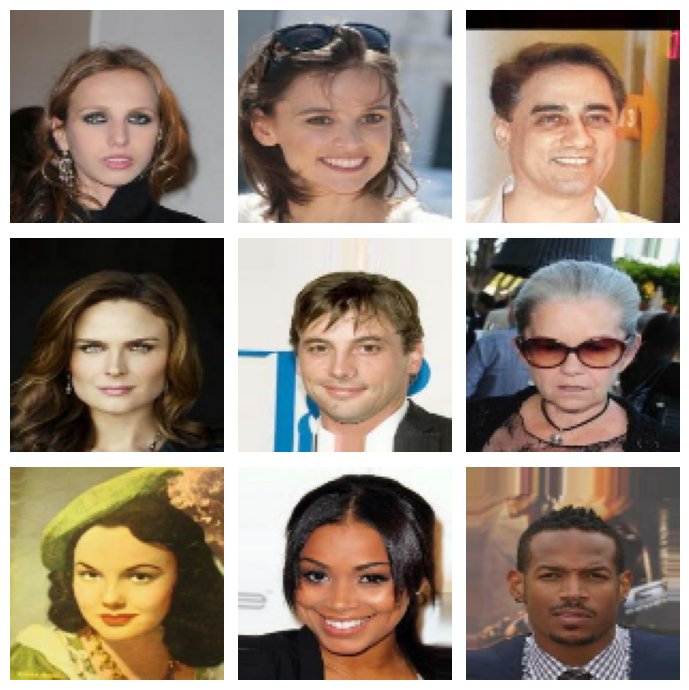

In [2]:
BATCH_SIZE = 128
IMG_HEIGHT = 100
IMG_WIDTH = 100

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Users/abdulbari/Downloads/img_align_celeba",
    seed=42,
    label_mode=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

import random

total_batches = tf.data.experimental.cardinality(dataset=dataset).numpy()
rand_batch_index = random.randint(0, total_batches-1)

plt.figure(figsize=(7, 7))
for images in dataset.skip(rand_batch_index).take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rand_img_index = random.randint(0, BATCH_SIZE-1)
    plt.imshow(images[rand_img_index].numpy().astype("uint8"))
    plt.axis(False)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [3]:
def preprocess_images(dataset):
    dataset = dataset.map(lambda image: tf.cast(image, tf.float32) / 255.0)
    dataset = dataset.take(2**12)
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    print(dataset.as_numpy_iterator().next()[0].shape)

preprocess_images(dataset)

2024-11-01 16:40:13.423681: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 100, 100, 3)


# Generator

In [4]:
def build_generator():
    generator = tf.keras.Sequential([

        tf.keras.layers.Dense(128*25*25, input_shape=[128], activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Reshape((25,25,128)),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(64, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),        

        tf.keras.layers.Conv2D(16, 7, padding="same", activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(3, 7, padding="same", activation="sigmoid")

    ])
    return generator

gen = build_generator()
gen.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80000)          │    10,320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80000)          │       320,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 128)  │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 64)   │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 32)   │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 16)   │        25,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 3)    │         2,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,580,131 (51.80 MB)

 Trainable params: 13,419,139 (51.19 MB)

 Non-trainable params: 160,992 (628.88 KB)

# Visualising Untrained Generated Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


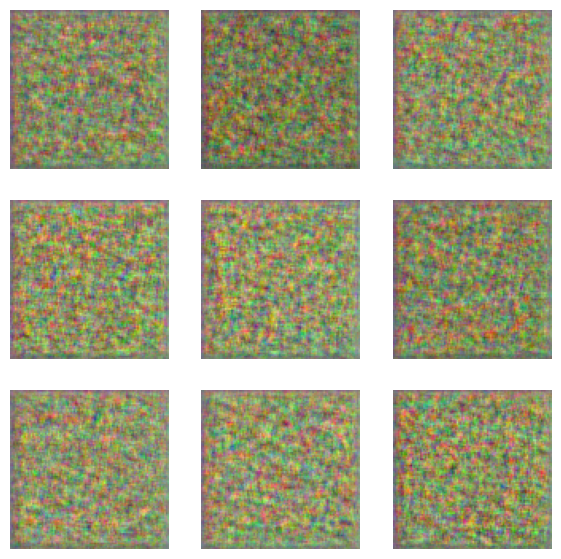

In [5]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = gen.predict(np.random.randn(1,128))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(np.squeeze(img))
    plt.axis(False)

# Discriminator

In [6]:
def build_discriminator():
    discriminator = tf.keras.Sequential([

        tf.keras.layers.Conv2D(128, 10, input_shape=[100,100,3], padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(256, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(192, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(16, 10, padding="same", activation="leaky_relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return discriminator

disc = build_discriminator()
disc.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 128)  │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 256)  │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 192)  │     4,915,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 128)  │     2,457,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 100, 100, 64)   │       819,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 100, 100, 32)   │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 100, 100, 16)   │        51,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,927,281 (45.50 MB)

 Trainable params: 11,925,649 (45.49 MB)

 Non-trainable params: 1,632 (6.38 KB)

# Custom Training Loop

In [7]:
gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
disc_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

gen_loss = tf.keras.losses.BinaryCrossentropy()
disc_loss = tf.keras.losses.BinaryCrossentropy()

In [8]:
from tensorflow.keras.models import Model

class CelebGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.gen_opt = gen_opt
        self.disc_opt = disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss

    def train_step(self, data):
        real_images = data
        generated_images = self.generator(tf.random.normal((BATCH_SIZE, 128)))

        with tf.GradientTape() as d_tape:
            generated_image_predictions = self.discriminator(generated_images, training=True)
            real_image_predictions = self.discriminator(real_images, training=True)
            disc_predictions = tf.concat([generated_image_predictions, real_image_predictions], axis=0)
            disc_labels = tf.concat([tf.ones_like(generated_image_predictions), tf.zeros_like(real_image_predictions)], axis=0)

            noise_generated_image_predictions = -0.1*tf.random.uniform(tf.shape(generated_image_predictions))
            noise_real_image_predictions = 0.1*tf.random.uniform(tf.shape(real_image_predictions))
            disc_labels += tf.concat([noise_generated_image_predictions, noise_real_image_predictions], axis=0)

            total_disc_loss = self.disc_loss(disc_labels, disc_predictions)

            disc_grad = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
            self.disc_opt.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            new_generated_images = self.generator(tf.random.normal((BATCH_SIZE, 128)), training=True)
            generator_predictions = self.discriminator(new_generated_images, training=False)

            total_gen_loss = gen_loss(tf.zeros_like(generator_predictions), generator_predictions)

            gen_grad = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))

        return {"disc_loss": total_disc_loss, "gen_loss": total_gen_loss}


In [9]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, save_img_every=5, save_weights_every=50):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_img_every = save_img_every
        self.save_weights_every = save_weights_every
        self.save_dir = '/Users/abdulbari/Desktop/ML/CelebGAN'

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_img_every == 0:
          random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images *= 255
          generated_images.numpy()
          for i in range(self.num_img):
              img = array_to_img(generated_images[i])
              img.save(os.path.join(self.save_dir, f"image_{epoch}_{i}.png"))

        if epoch % self.save_weights_every == 0:
            model_save_path = os.path.join(self.save_dir, f"gan_weights_epoch_{epoch}.weights.h5")
            self.model.generator.save_weights(model_save_path)
            print(f"Model weights saved to {model_save_path}")

In [10]:
celeb = CelebGAN(gen, disc)
celeb.compile(gen_opt, disc_opt, gen_loss, disc_loss)

In [11]:
steps_per_epoch = 202599 // BATCH_SIZE
history = celeb.fit(dataset, epochs=300, steps_per_epoch=100 , callbacks=[ModelMonitor()])

Epoch 1/300
